**Welcome to implementationn of the sift-method**

We need to install a corresponding version because the algorithm is patented. 

In [1]:
!pip install opencv-contrib-python==4.4.0.44

**Import libraries**

In [48]:
import cv2
print(cv2.__version__)

4.4.0


In [49]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.activations import linear, sigmoid, tanh, relu

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix,accuracy_score, classification_report
from sklearn.cluster import KMeans

from scipy.cluster.vq import kmeans,vq
from scipy import ndimage
from scipy.spatial import distance
from skimage.feature import hog, local_binary_pattern
from natsort import natsorted

from string import ascii_uppercase

**Loading data from module data_augmentation**

In [4]:
import import_ipynb

# Import module data-augmentation
from data_augmentation import x_train, x_test, y_train, y_test, x_train_norm, x_test_norm, x_train_gray, x_test_gray

In [23]:
print(f'From module data_augmentation imports following:')
print("")
print("x_train, x_test, y_train, y_test, x_train_norm, x_test_norm, x_train_gray, x_test_gray")
print("")
print(f'1. There are {len(x_train_norm)} images normalized for training and {len(x_test_norm)} for testing')
print(f'2. There are {len(y_train)} labels for training and {len(y_test)} for testing')

From module data_augmentation imports following:

x_train, x_test, y_train, y_test, x_train_norm, x_test_norm, x_train_gray, x_test_gray

1. There are 88 images normalized for training and 22 for testing
2. There are 88 labels for training and 22 for testing


 **SIFT METHOD**

**Function to extract features**

In [13]:
def apply_sift(list_image,n_kp):
  one,two,thr=np.shape(list_image)
  all_k_sift=[]#value of fetyre
  all_f_sift=[]#np.empty(n_kp,128)#value of fetyre

  for i in range(one):
    image=list_image[i]
    image =cv2.convertScaleAbs(image)
    sift = cv2.SIFT.create(nfeatures = n_kp )
    k_sift,f_sift= sift.detectAndCompute(image,None)
    dim1,dim2=np.shape(f_sift)
    if dim1 != n_kp:
      for j in range(dim1-n_kp-1):
        print(j)
        f_sift=np.delete(f_sift, (n_kp+j), axis=0)


    #print(np.shape(f_sift))
    all_f_sift.append(f_sift)
    all_k_sift.append(k_sift)
   
  return all_k_sift,all_f_sift

In [14]:
train_sift_kp, train_sift_f = apply_sift(x_train_norm,250)
test_sift_kp, test_sift_f = apply_sift(x_test_norm,250)

**Caracteristicas de entrenamiento**

In [16]:
print(f'There are {train_sift_f[0].shape[0]} features & {train_sift_f[0].shape[1]} values, for {len(train_sift_f)} descriptor to training')

There are 116 features & 128 values, for 88 descriptor to training


**Caracteristicas de validacion**

In [17]:
print(f'There are {test_sift_f[0].shape[0]} features & {test_sift_f[0].shape[1]} values, for {len(test_sift_f)} descriptors to testing')

There are 198 features & 128 values, for 22 descriptors to testing


**Visualizing keypoints**

In [18]:
def keypointImage(image,images_gray):
  sift = cv2.SIFT.create()
  kp = sift.detect(images_gray,None)
  output = cv2.drawKeypoints(image, kp, None)

  return output

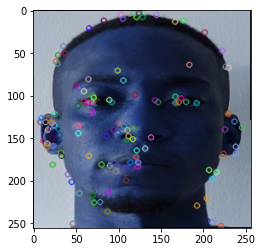

In [27]:
keypoint = keypointImage(x_train[80], x_train_gray[80])
plt.imshow(keypoint)

 **CREATING MODELS AND CLUSTER**

1. Define a function that return true classes given by y_test.
2. Create structure of the models (Multilayer Perceptron MLP, Support Vector Classifier (SVC)).
3. Create clustering with Kmeans, this is going to be the input of our models.

**True class function**

In [28]:
true_classes = []

def trueClass():
  for i in y_test:
      if i==1:
          true_classes.append("gilber")
      else:
          true_classes.append("jhon")
  true = true_classes[:len(y_test)]
  return true

true_classes = trueClass()

**Multi-Layer Perceptron (MLP)**

In [30]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(1000,), activation = "relu", learning_rate="constant", random_state=1, max_iter=1000, verbose = True)

**Support Vector Classifier (SVC)**

In [31]:
svc_classifier = LinearSVC(dual=True, loss='squared_hinge', max_iter=80000, multi_class='ovr', penalty='l2')

**Clustering con Kmeans**

In [32]:
def kmeansModel(k, descriptor_list):
  n=np.array(descriptor_list)
  one=np.shape(n)

  list_center=[]

  for i in range(one[0]):
    #kmeans = KMeans(n_clusters = k, n_init=30).fit(np.transpose(descriptor_list[posicion_img_neutral][:][:]))
    kmeans = KMeans(n_clusters = k, n_init=30).fit(descriptor_list[i])
    kmeans.predict(descriptor_list[i])
    centers=kmeans.cluster_centers_
    list_center.append(centers.flatten())
  
  return list_center

In [33]:
w = 10

feature_train_sift = kmeansModel(w,train_sift_f)
feature_test_sift = kmeansModel(w,test_sift_f)

/tmp/ipykernel_22224/2064150906.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  n=np.array(descriptor_list)
/tmp/ipykernel_22224/2064150906.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  n=np.array(descriptor_list)


**IMPLEMENTATION OF THE MODELS MLP,SVC - SIFT**

 **Training and validation MLP model**

In [34]:
feature_train_sift[0].shape

(1280,)

In [35]:
mlp_model_sift = mlp_classifier.fit(feature_train_sift, np.array(y_train.flatten()))

Iteration 1, loss = 7.40310319
Iteration 2, loss = 18.02246613
Iteration 3, loss = 1.35327966
Iteration 4, loss = 18.02246658
Iteration 5, loss = 18.02246680
Iteration 6, loss = 6.66589870
Iteration 7, loss = 16.91977476
Iteration 8, loss = 17.92082797
Iteration 9, loss = 17.14122839
Iteration 10, loss = 3.07708964
Iteration 11, loss = 2.64200947
Iteration 12, loss = 15.51147322
Iteration 13, loss = 15.42836609
Iteration 14, loss = 6.54049128
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


**Prediction of the model**

In [36]:
sift_mlp_pred = mlp_model_sift.predict(feature_test_sift)

In [37]:
predict_sift_mlp = []

for i in sift_mlp_pred:
    if i==1:
        predict_sift_mlp.append("gilber")
    else:
        predict_sift_mlp.append("jhon")

print("True labels:")
print("")
print(true_classes)
print("")
print("Predicted labels MLPxSIFT:")
print("")
print(predict_sift_mlp)

True labels:

['gilber', 'gilber', 'gilber', 'jhon', 'jhon', 'gilber', 'jhon', 'jhon', 'jhon', 'jhon', 'gilber', 'jhon', 'gilber', 'jhon', 'jhon', 'gilber', 'gilber', 'jhon', 'gilber', 'jhon', 'gilber', 'gilber']

Predicted labels MLPxSIFT:

['jhon', 'jhon', 'gilber', 'jhon', 'jhon', 'gilber', 'jhon', 'jhon', 'jhon', 'jhon', 'jhon', 'jhon', 'jhon', 'jhon', 'jhon', 'gilber', 'gilber', 'jhon', 'gilber', 'jhon', 'jhon', 'gilber']


**Accuracy**

In [38]:
accuracy_sift_mlp = accuracy_score(true_classes, predict_sift_mlp)
print(accuracy_sift_mlp)

0.7727272727272727


 **Training and validation SVC model**

In [39]:
svc_model_sift = svc_classifier.fit(feature_train_sift, np.array(y_train.flatten()))

**Prediciton of the model SVCxSIFT**

In [40]:
sift_svc_pred = svc_model_sift.predict(feature_test_sift)

In [41]:
predict_sift_svc = []

for i in sift_svc_pred:
    if i == 1:
        predict_sift_svc.append("gilber")
    else:
        predict_sift_svc.append("jhon")

print("True classes")
print("")
print(predict_sift_svc)
print("")
print("Predicted classes - SVCxSIFT")
print("")
print(true_classes)

True classes

['gilber', 'gilber', 'gilber', 'jhon', 'jhon', 'gilber', 'jhon', 'gilber', 'jhon', 'jhon', 'gilber', 'gilber', 'gilber', 'jhon', 'jhon', 'gilber', 'gilber', 'jhon', 'gilber', 'jhon', 'gilber', 'gilber']

Predicted classes - SVCxSIFT

['gilber', 'gilber', 'gilber', 'jhon', 'jhon', 'gilber', 'jhon', 'jhon', 'jhon', 'jhon', 'gilber', 'jhon', 'gilber', 'jhon', 'jhon', 'gilber', 'gilber', 'jhon', 'gilber', 'jhon', 'gilber', 'gilber']


**Accuracy model SVCxSIFT**

In [42]:
accuracy_sift_svc = accuracy_score(true_classes, predict_sift_svc)
print(accuracy_sift_svc)

0.9090909090909091


**CONFUSION MATRIX OF THE MODELS**

**Confusion matrix model MLP x SIFT**

In [43]:
confm_mlp_sift = confusion_matrix(y_test.flatten(), sift_mlp_pred)
confm_mlp_sift

array([[11,  0],
       [ 5,  6]])

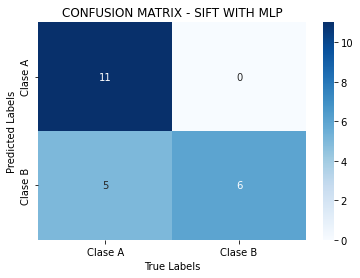

In [52]:
confm_mlp_sift = confusion_matrix(y_test.flatten(), sift_mlp_pred)
columna_sift_mlp = ['Clase %s'%(i) for i in list(ascii_uppercase)[0:len(np.unique(sift_mlp_pred))]]
df_cm_sift_mlp = pd.DataFrame(confm_mlp_sift, index= columna_sift_mlp, columns = columna_sift_mlp)

graph_cm_sift_mlp = sns.heatmap(df_cm_sift_mlp, cmap=plt.cm.Blues, annot = True)

plt.title('CONFUSION MATRIX - SIFT WITH MLP')
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.show()


**Confusion matrix model SVC x SIFT**

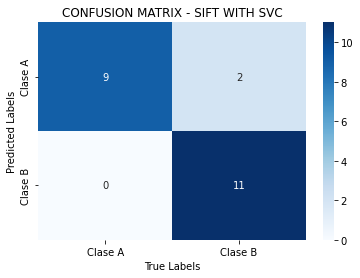

In [53]:
confm_svc_sift = confusion_matrix(y_test.flatten(), sift_svc_pred)
columna_sift_svc = ['Clase %s'%(i) for i in list(ascii_uppercase)[0:len(np.unique(sift_svc_pred))]]
df_cm_sift_svc = pd.DataFrame(confm_svc_sift, index= columna_sift_svc, columns = columna_sift_svc)

graph_cm_sift_svc = sns.heatmap(df_cm_sift_svc, cmap=plt.cm.Blues, annot = True)

plt.title('CONFUSION MATRIX - SIFT WITH SVC')
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.show()